## Tracking President Biden’s July 4th, 2021 “Independence” from the Covid-19 Virus
by Joffrey Inocencio

In [1]:
import requests
from datetime import datetime
import pandas as pd

## COVID-19 Vaccine Data

https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations

In [2]:
VAC_DATA = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv'

In [3]:
vac_df = pd.read_csv(VAC_DATA)
vac_df.head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN


## COVID-19 Cases Data

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

In [4]:
from bs4 import BeautifulSoup
import requests
import re

In [5]:
# folder of file names
URL = 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports_us'
# url for files in raw form
RAW_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/{}'

Use BeautifulSoup to parse through GitHub folder of file names 

In [6]:
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
# get information regarding csv files
csv_soup = soup.find_all(href=re.compile("csv"))

# extract file names
file_list = []
for title in csv_soup:
    # csv files are mapped to 'title'
    csv_title = title.get('title')
    file_list.append(csv_title)
len(file_list)

399

At the time of building this data collection, It looks like there are 352 dates in the COVID-19 Cases dataset folder. For this project, we will likely only want to associate our testing dates with the vaccine data dates.

In [7]:
from datetime import datetime

In [8]:
# get dates from the file names in the dataset folder 
dates = [s.strip('.csv') for s in file_list]

Retrieve files as early as a specified date

In [9]:
# set start date of data retrieval
start_date = datetime.strptime('01-12-2021', '%m-%d-%Y')   # start date of vaccine data collection

# create list of dates that range from the start_date to the current most date in dataset folder
mod_dates = [i for i in dates if start_date <= datetime.strptime(i, '%m-%d-%Y')]

# create list of raw_URL file path and append '.csv' to the date 
mod_file_list = [RAW_URL.format(i + '.csv') for i in mod_dates]

# check output
mod_file_list[0]

'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/01-12-2021.csv'

In [10]:
# place data into a list (seems faster this way compared to directly to DF)
li=[]
i=0
for file in mod_file_list:
    df = pd.read_csv(file)
    df['date'] = mod_dates[i]
    li.append(df)
    i +=1
cases_df = pd.concat(li, axis=0, ignore_index=True)

In [11]:
# drop cols
drop_cols=['Country_Region', 'FIPS', 'Last_Update', 'Lat', 'Long_','UID', 'ISO3', 'People_Hospitalized', 'Hospitalization_Rate' ]
cases_df.drop(columns=drop_cols, inplace=True)
cases_df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,date
0,Alabama,407848,5573,211684.0,190591.0,8318.021857,1981019.0,1.366440,40402.697430,01-12-2021
1,Alaska,50544,225,7165.0,43132.0,6906.205360,1357708.0,0.445351,185594.597735,01-12-2021
2,American Samoa,0,0,NaN,0.0,0.000000,2140.0,NaN,3846.084722,01-12-2021
3,Arizona,636100,10482,86757.0,538861.0,8739.177523,5742443.0,1.647854,42806.225328,01-12-2021
4,Arkansas,259553,4121,229700.0,25732.0,8600.724235,2208736.0,1.587730,73190.174047,01-12-2021


## Merge Vaccine data and Cases data into a single dataframe

Match date format

In [12]:
cases_df.rename(columns={'Province_State':'location'}, inplace=True)
cases_df['date'].head()

0    01-12-2021
1    01-12-2021
2    01-12-2021
3    01-12-2021
4    01-12-2021
Name: date, dtype: object

In [13]:
vac_df['date']= pd.to_datetime(vac_df['date']).dt.strftime('%m-%d-%Y')
vac_df['date'].head(5)

0    01-12-2021
1    01-13-2021
2    01-14-2021
3    01-15-2021
4    01-16-2021
Name: date, dtype: object

In [14]:
df = pd.merge(cases_df, vac_df, on=['location', 'date'], how='inner')
df.head(50)

,location,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,date,...,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,Alabama,407848,5573,211684.0,190591.0,8318.021857,1981019.0,1.366440,40402.697430,01-12-2021,...,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
1,Alaska,50544,225,7165.0,43132.0,6906.205360,1357708.0,0.445351,185594.597735,01-12-2021,...,22486.0,0.74,4.90,5400.0,3.07,19.36,NaN,NaN,NaN,0.253
2,American Samoa,0,0,NaN,0.0,0.000000,2140.0,NaN,3846.084722,01-12-2021,...,842.0,0.47,3.81,260.0,1.51,19.12,NaN,NaN,NaN,0.199
3,Arizona,636100,10482,86757.0,538861.0,8739.177523,5742443.0,1.647854,42806.225328,01-12-2021,...,95141.0,0.11,1.94,8343.0,1.31,7.74,NaN,NaN,NaN,0.251
4,Arkansas,259553,4121,229700.0,25732.0,8600.724235,2208736.0,1.587730,73190.174047,01-12-2021,...,39357.0,0.00,1.35,8.0,1.30,9.09,NaN,NaN,NaN,0.149
5,California,2832085,31345,NaN,2773506.0,7098.216165,36508384.0,1.110900,92397.696784,01-12-2021,...,703540.0,0.25,2.07,100089.0,1.78,8.32,NaN,NaN,NaN,0.248
6,Colorado,364336,5242,19328.0,339766.0,6326.666130,4821636.0,1.438782,83727.331831,01-12-2021,...,187838.0,0.63,3.90,36425.0,3.26,8.97,NaN,NaN,NaN,0.434
7,Connecticut,217047,6449,9800.0,200798.0,6087.784798,4771175.0,2.971246,133823.027431,01-12-2021,...,56350.0,0.12,4.25,4174.0,1.58,7.03,NaN,NaN,NaN,0.604
8,Delaware,66446,1157,18851.0,46604.0,6823.624615,1073700.0,1.491437,110262.856298,01-12-2021,...,15911.0,0.29,2.71,2784.0,1.63,9.07,NaN,NaN,NaN,0.299
9,District of Columbia,32423,825,22464.0,9134.0,4594.126240,970048.0,2.544490,137449.433155,01-12-2021,...,NaN,NaN,4.22,NaN,NaN,8.89,NaN,NaN,NaN,0.475


# Understanding the Data

## Data Preprocessing

In [15]:
import matplotlib.pyplot as plt

In [16]:
location = df.location.unique()
location

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Where is New York? 

In [17]:
df.columns

Index(['location', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Incident_Rate', 'Total_Test_Results', 'Case_Fatality_Ratio',
       'Testing_Rate', 'date', 'total_vaccinations', 'total_distributed',
       'people_vaccinated', 'people_fully_vaccinated_per_hundred',
       'total_vaccinations_per_hundred', 'people_fully_vaccinated',
       'people_vaccinated_per_hundred', 'distributed_per_hundred',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'share_doses_used'],
      dtype='object')

Since we have daily vaccination counts, it may be useful to have a daily count of new cases, or 'new infections'. Lets estimate this by taking the difference of confirmed cases over a 10 day period.
Note: Predictions can vary drastically when choosing to calculate new infections over 2,5,7,or 10 days.. etc

In [18]:
new_infections_days_interval = 7
df['new_infections'] = df.groupby("location")['Confirmed'].diff(periods=new_infections_days_interval)

# fill in first few dates from each location with the maximum value found in a location's 'new infection'
df.loc[df['new_infections'].isnull(), 'new_infections'] = df['location'].map(df.groupby('location')['new_infections'].max())


In [19]:
df.set_index('date',inplace=True)

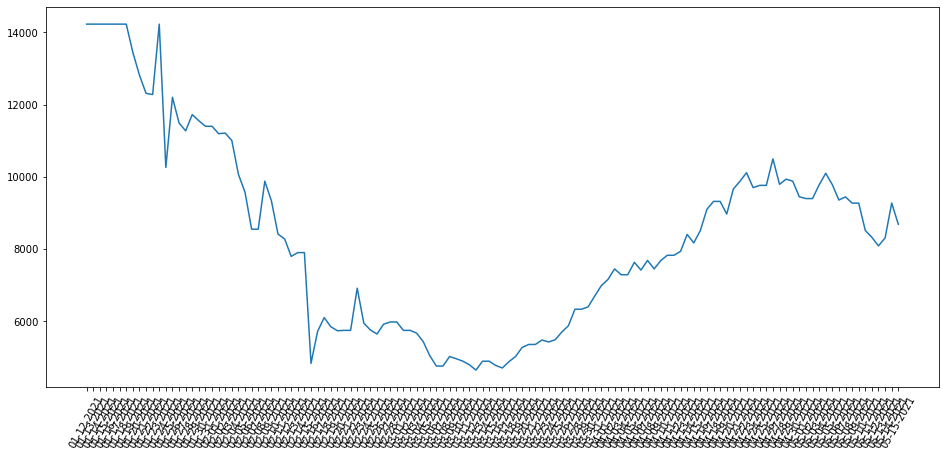

In [20]:
plt.figure(figsize=(16,7))
plt.xticks(rotation=60)
plt.plot(df.loc[df['location'] == "Washington"]['new_infections']);

#### Data Cleaning

In [21]:
import seaborn as sns

In [22]:
df.isnull().sum()/len(df)

location                               0.000000
Confirmed                              0.000000
Deaths                                 0.000000
Recovered                              0.670821
Active                                 0.564516
Incident_Rate                          0.000000
Total_Test_Results                     0.000000
Case_Fatality_Ratio                    0.018182
Testing_Rate                           0.000000
total_vaccinations                     0.032258
total_distributed                      0.032258
people_vaccinated                      0.034018
people_fully_vaccinated_per_hundred    0.043695
total_vaccinations_per_hundred         0.032258
people_fully_vaccinated                0.043695
people_vaccinated_per_hundred          0.034018
distributed_per_hundred                0.032258
daily_vaccinations_raw                 0.008065
daily_vaccinations                     0.008065
daily_vaccinations_per_million         0.008065
share_doses_used                       0

Drop columns with more than 25% data

In [23]:
df.drop(['Recovered', 'Active'], inplace=True, axis=1)

Fill in missing data (default is fill forward)

In [24]:
df.interpolate(method='linear', limit_direction='backward', inplace=True)

#### Data Reduction - Feature Selection

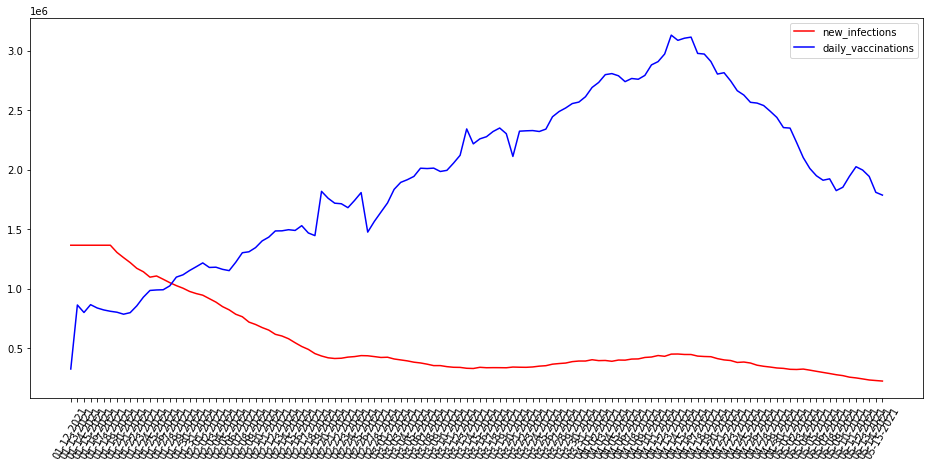

In [25]:
plt.figure(figsize=(16,7))
plt.xticks(rotation=60)
plt.plot(df['new_infections'].groupby('date').sum(), color='red', label='new_infections');
plt.plot(df['daily_vaccinations'].groupby('date').sum(), color='blue', label='daily_vaccinations');
plt.legend()
plt.show()

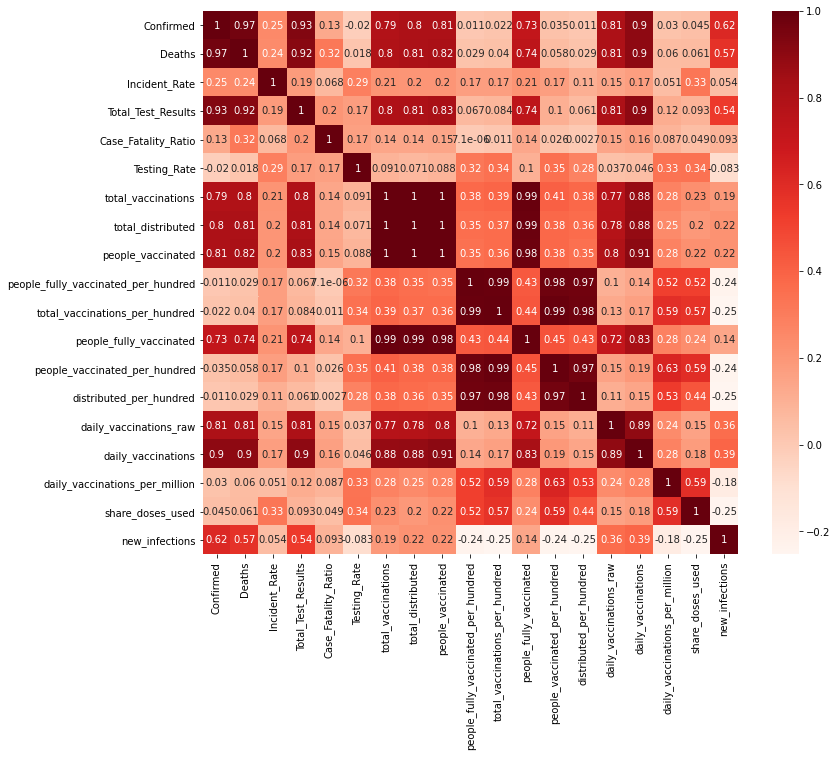

In [26]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Relevant featuresthat coincide with 'new_infections'. Negative values were used since we expect an inverse relationship between new infections and vaccine deployment

In [27]:
#Correlation with output variable
cor_target = cor["new_infections"]

relevant_features = cor_target[cor_target<-0.1] 
relevant_features_list = relevant_features.index.tolist()
relevant_features_list.extend((['new_infections','location']))
relevant_features_list

['people_fully_vaccinated_per_hundred',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'distributed_per_hundred',
 'daily_vaccinations_per_million',
 'share_doses_used',
 'new_infections',
 'location']

In [28]:
df_filt = df.reindex(relevant_features_list, axis=1)

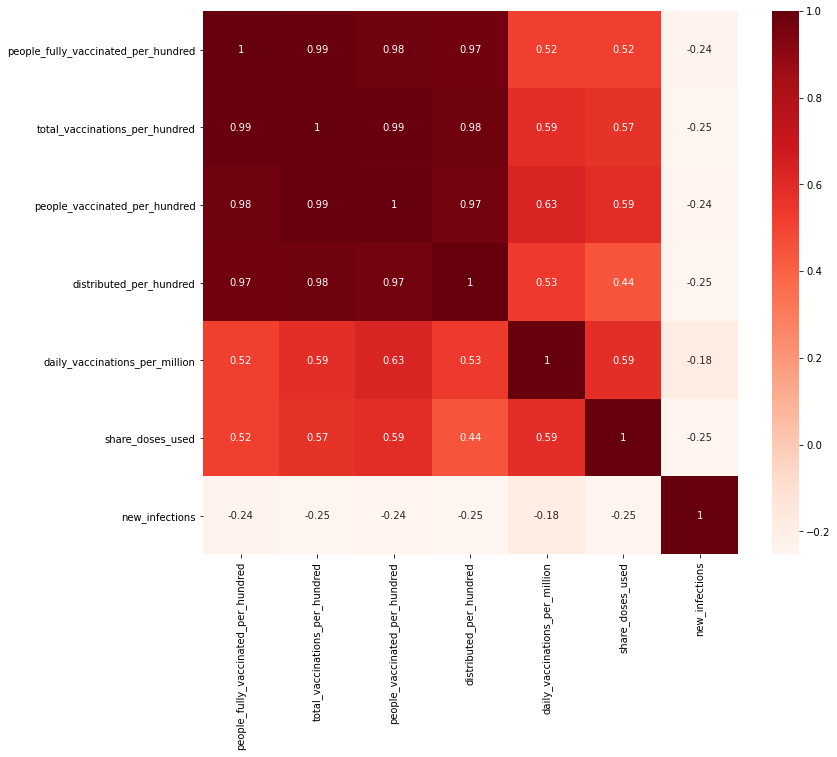

In [29]:
plt.figure(figsize=(12,10))
cor2 = df_filt.corr()
sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
plt.show()

## Model Fitting

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [31]:
location = df.location.unique()
mapping = dict(zip(location, range(len(location))))
df_filt['location'].replace(mapping, inplace = True)

In this model, we are using vaccine data to predict number of new infections

In [32]:
def get_lr_model(location, feature):
    loc = mapping.get(location)
    
    X = df_filt.loc[df_filt['location'] == loc].drop([feature], axis=1)
    y = df_filt.loc[df_filt['location'] == loc][feature]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LinearRegression().fit(X_train, y_train)

    return model, X_test, y_test

Scoring the Linear Regression model

In [33]:
score = {}
for location in mapping.keys():
    prediction_model, X_test, y_test = get_lr_model(location, 'new_infections')   
    r2_score = prediction_model.score(X_test, y_test)
    score.update({location: r2_score})
score = pd.Series(score)
score.describe()

count    55.000000
mean      0.869052
std       0.156922
min       0.227967
25%       0.851358
50%       0.927042
75%       0.956317
max       1.000000
dtype: float64

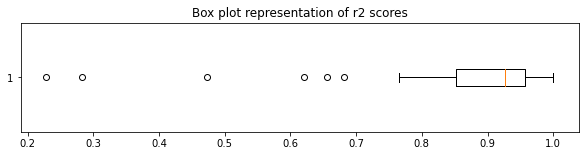

In [34]:
plt.figure(figsize=(10,2))
plt.title("Box plot representation of r2 scores")
plt.boxplot(score, vert=False);

Scores look great. Let's visualize a comparison of the model with its expected value

In [35]:
def plot_model(location):
    state = mapping.get(location)
    prediction_model, X_test, y_test = get_lr_model(location, 'new_infections')
    
    plt.figure(figsize=(15,7))
    plt.plot(prediction_model.predict(df_filt.loc[df_filt['location'] == state].drop(['new_infections'], axis=1)), label='prediction')
    plt.plot(df_filt.loc[df_filt['location'] == state]['new_infections'], color='red', label='expected');
    plt.xticks(rotation='vertical')
    plt.title("Predicting New Infections in " +location+ " Using Vaccine Data")
    plt.ylabel("Number of New Infections")
    plt.xlabel("Date") 
    plt.legend()

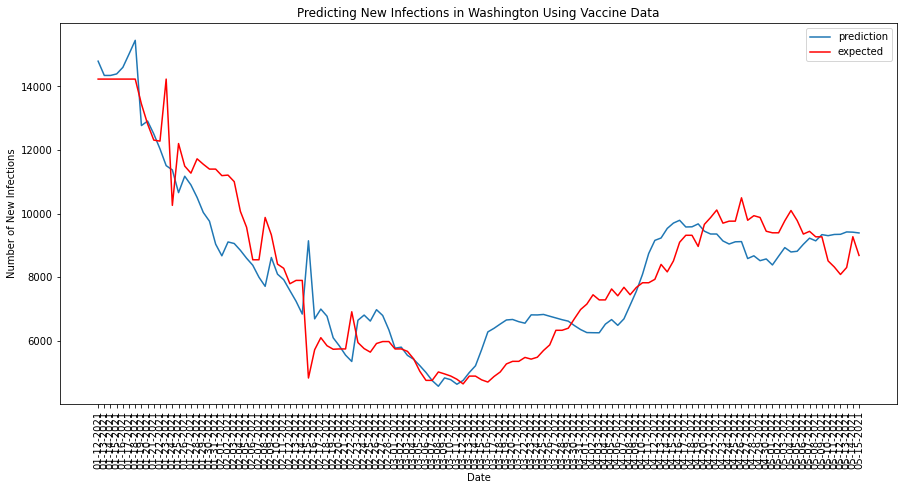

In [36]:
plot_model("Washington")

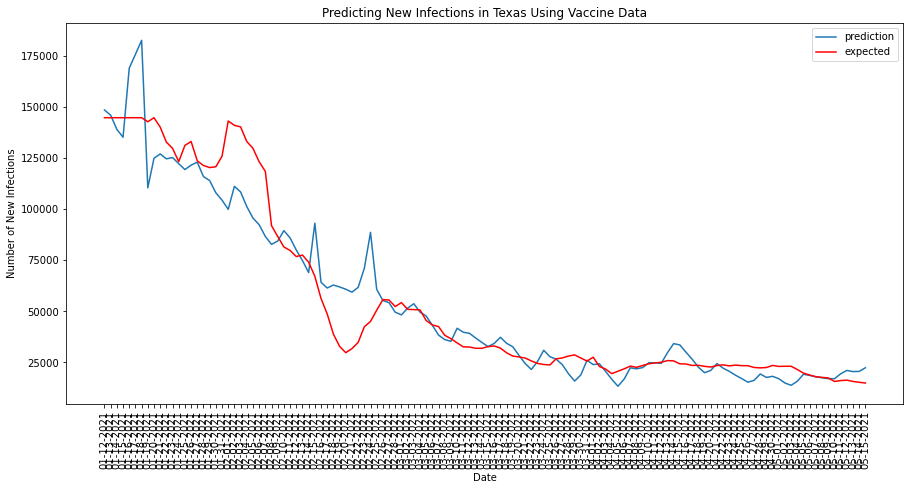

In [37]:
plot_model("Texas")

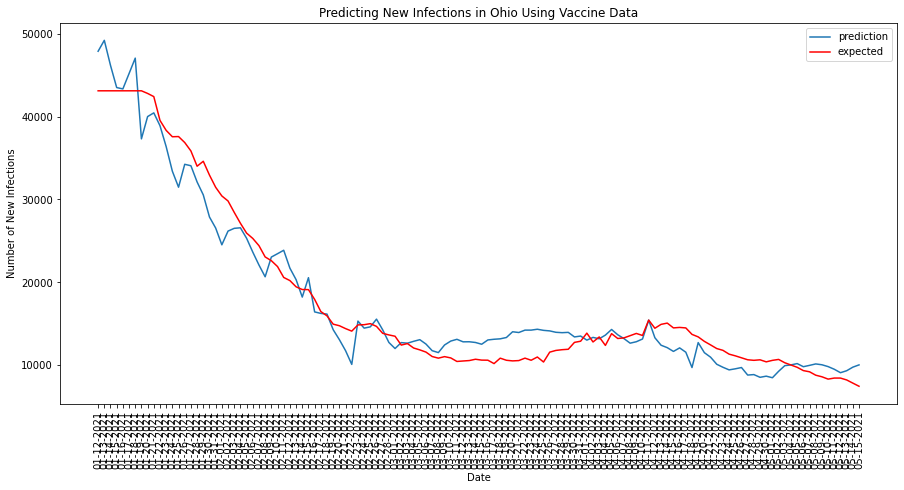

In [38]:
plot_model("Ohio")

Seems as though a linear regression of our vaccine data does a decent job overall in predicting new_infections over the time frame. We can apply this model to estimate future new_infections by forecasting our correlated vaccine features toward  future days. 

# Forecasting

In [39]:
from statsmodels.tsa.arima.model import ARIMA

In [40]:
import warnings
warnings.filterwarnings('ignore')

Using an ARIMA Model
    <li> p is the order of the AR term    
    <li>d is the number of differencing required to make the time series stationary    
    <li>q is the order of the MA term

In [41]:
def forecast_model(location, feature, days_out):
    loc = mapping.get(location)
    
    X = df_filt.loc[df_filt['location'] == loc][feature]
    
    # p is the order of the AR term    
    # d is the number of differencing required to make the time series stationary    
    # q is the order of the MA term
    p,d,q = (1,2,2)
    
    model = ARIMA(X, order=(p,d,q), freq='D')
    model_fit = model.fit()
    model_fit.forecast(days_out).index = pd.to_datetime(model_fit.forecast(days_out).index)
    return model_fit.forecast(days_out)

In [42]:
def plot_forecast(location, days):
    state = mapping.get(location)
    prediction_model, X_test, y_test = get_lr_model(location, 'new_infections')
#     df_filt.index = pd.to_datetime(df_filt.index)
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_filt.loc[df_filt['location'] == state]['new_infections'], color='red', label='actual');  
    plt.plot(forecast_new_infections(location, days), label='prediction')
    
    plt.xticks(rotation='vertical')
    plt.title("Predicting New Infections in " +location+ " Using Vaccine Data")
    plt.ylabel("Number of New Infections")
    plt.xlabel("Date") 
    plt.legend()

In [43]:
df_filt.index = pd.to_datetime(df_filt.index)

Plotting forecasted 'people_fully_vaccinated_per_hundred' over 60 days to ensure pdq values "look" according to trend

In [44]:
def plot_forecasted_feature(location, feature, days):
    p = 1
    d = 2
    q = 2

    loc = mapping.get(location)

    plt.figure(figsize=(15,7))
    plt.plot(df_filt.loc[df_filt['location'] == loc][feature]);
    plt.plot(forecast_model(location,feature, days), label='forecasts')

    plt.xticks(rotation='vertical')
    plt.title("Forecasting next "+str(days)+ " days of "+feature+ " in " +location+ " Using Vaccine Data", fontsize=15)
    plt.ylabel("Number of " +feature, fontsize=12)
    plt.xlabel("Date") 
    plt.legend(fontsize=12);
    plt.show();

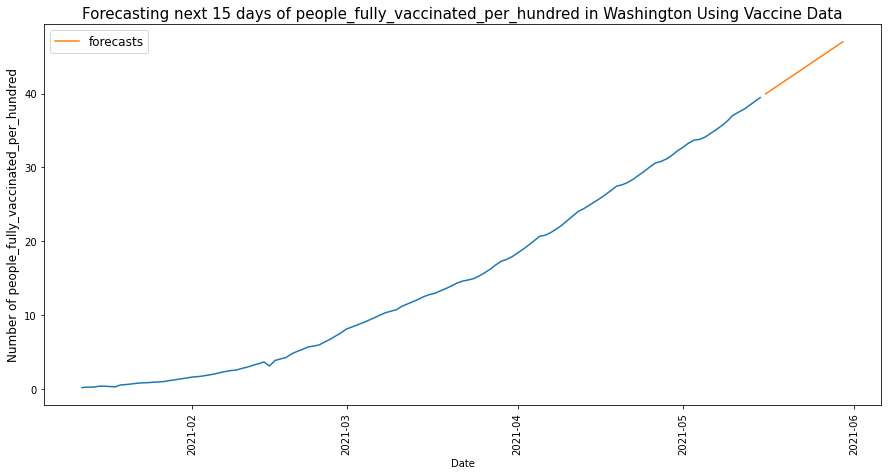

In [45]:
plot_forecasted_feature('Washington', 'people_fully_vaccinated_per_hundred', 15)

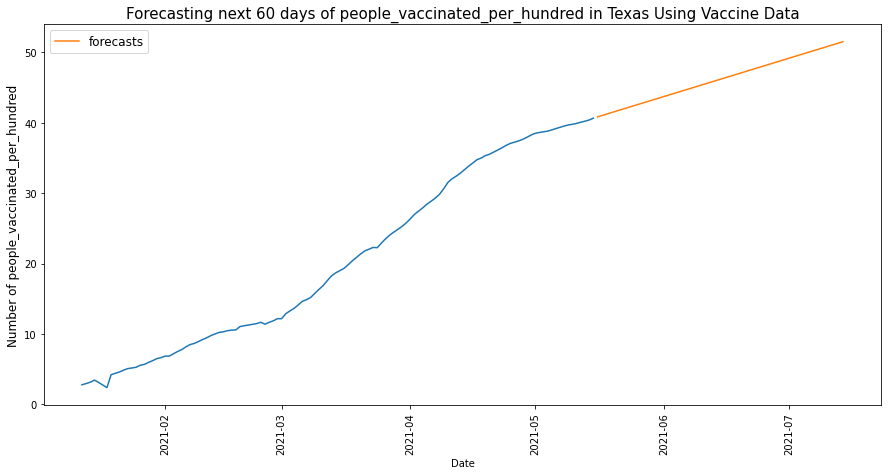

In [46]:
plot_forecasted_feature('Texas', 'people_vaccinated_per_hundred', 60)

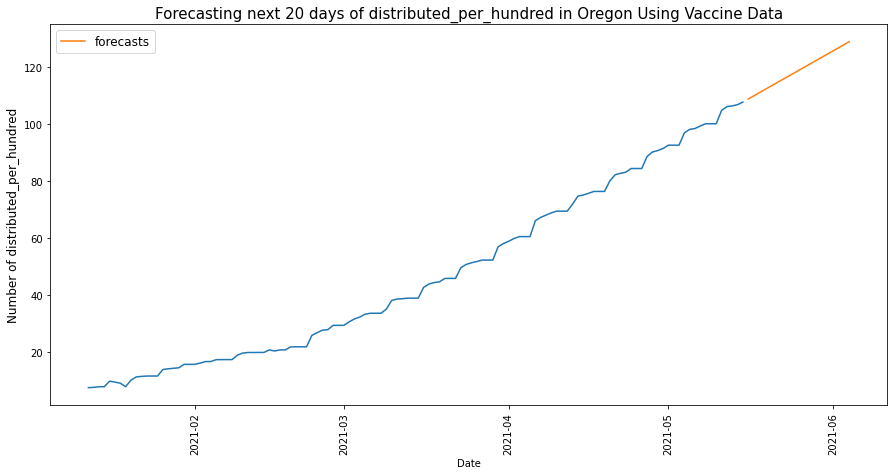

In [47]:
plot_forecasted_feature('Oregon', 'distributed_per_hundred', 20)

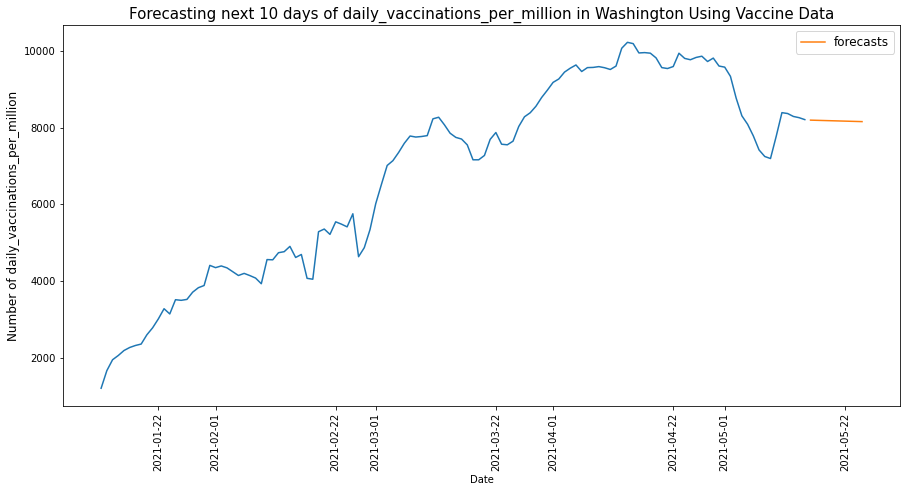

In [48]:
plot_forecasted_feature('Washington', 'daily_vaccinations_per_million', 10)

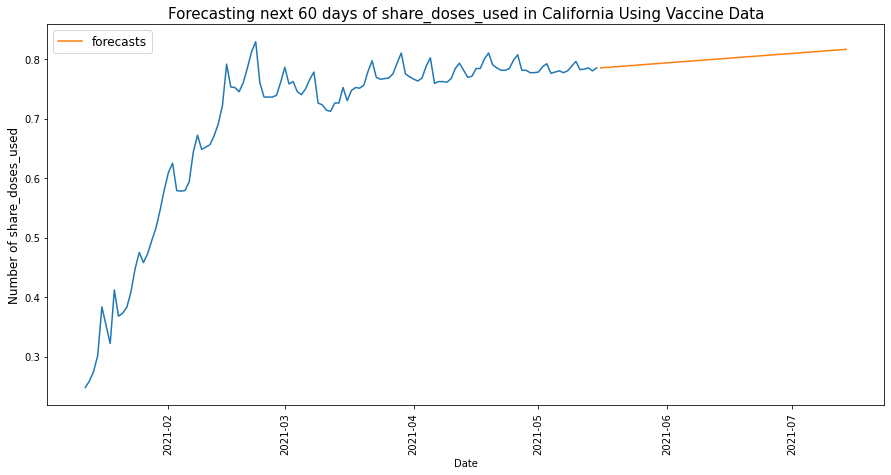

In [49]:
plot_forecasted_feature('California', 'share_doses_used', 60)

With share_doses_used, California, Washington, and Texas seem to have good predictions. However, Oregon does not

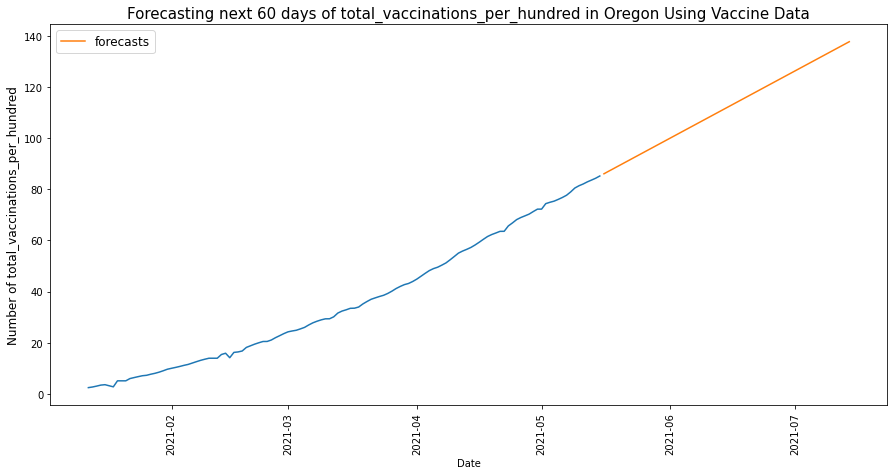

In [50]:
plot_forecasted_feature('Oregon', 'total_vaccinations_per_hundred', 60)

Forecast models 'looks' reasonable

In [51]:
forecast_features = df_filt.columns.to_list()
forecast_features.remove('new_infections')

#### Converting forecasted vaccine data back into a dataframe

In [52]:
def aggregate_state_forecast(location, days_out):
    li=[]
    for feature in forecast_features:
        data = forecast_model(location, feature, days_out)
        data.rename(feature)
        li.append(data)        
        forecasted_vac_df = pd.concat(li, axis=1, ignore_index=True)
    
    # Renaming columns
    mapping = dict(zip(forecast_features, range(len(forecast_features))))
    mapping = dict(zip(mapping.values(), mapping.keys()))
    forecasted_vac_df.rename(columns=mapping, inplace = True)
    
    return forecasted_vac_df

In [53]:
forecast_wa_vac_df=aggregate_state_forecast('Washington', 5)
forecast_wa_vac_df

,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_per_million,share_doses_used,location
2021-05-16,39.955012,89.101049,51.705584,110.194616,8194.034279,0.808310,51.0
2021-05-17,40.457813,89.830722,52.005875,111.147352,8189.440994,0.808114,51.0
2021-05-18,40.961832,90.576510,52.303452,112.091809,8185.156760,0.808118,51.0
2021-05-19,41.465180,91.331369,52.599638,113.033135,8180.883934,0.808203,51.0
2021-05-20,41.968898,92.091336,52.895110,113.973275,8176.611529,0.808320,51.0


## Results

In [54]:
def get_prediction_model(location):
    prediction_model,x,y = get_lr_model(location, 'new_infections')
    return prediction_model

In [55]:
def forecast_new_infections(location,days):
    forecast_state_vac_df=aggregate_state_forecast(location, days)
    prediction_model = get_prediction_model(location)
        
    return pd.Series(prediction_model.predict(forecast_state_vac_df), index=forecast_state_vac_df.index)

In [56]:
def plot_forecasted_new_infections(location, days):
    state = mapping.get(location)
    prediction_model = get_prediction_model(location)
    pred = prediction_model.predict(df_filt.loc[df_filt['location'] == state].drop(['new_infections'], axis=1))
    date_index = df_filt.loc[df_filt['location'] == state]['new_infections'].index.unique()
    
    pred_series = pd.Series(pred, index=date_index)
    
    plt.figure(figsize=(15,7))
    
    plt.plot(pred_series, color='blue')
    plt.plot(df_filt.loc[df_filt['location'] == state]['new_infections'], color='red', label='actual');  
    plt.plot(forecast_new_infections(location, days), color='blue', label='prediction')

    
    plt.xticks(rotation='vertical')
    plt.title("Predicting New Infections for the next " +str(days)+ " days in " +location+ " Using Vaccine Data", fontsize=20)
    plt.ylabel("Number of New Infections", fontsize=15)
    plt.xlabel("Date") 
    plt.legend()

In [57]:
days = 72

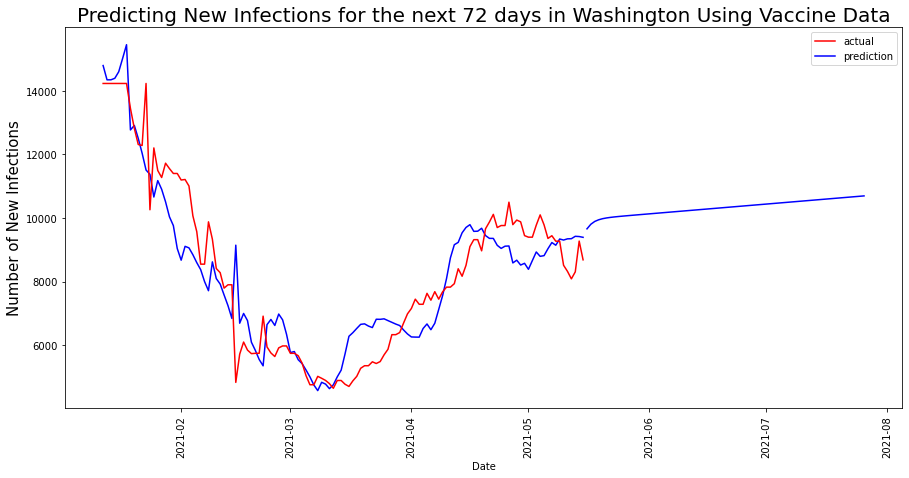

In [58]:
plot_forecasted_new_infections('Washington', days)

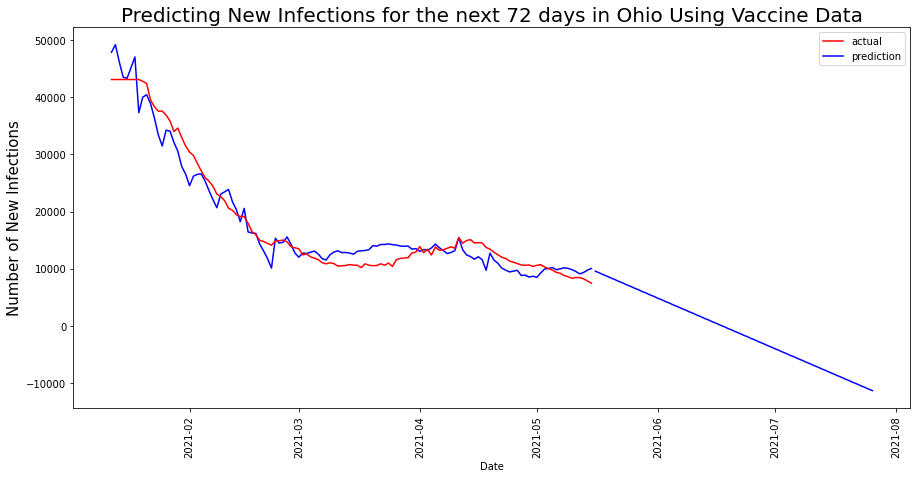

In [59]:
plot_forecasted_new_infections('Ohio',days)

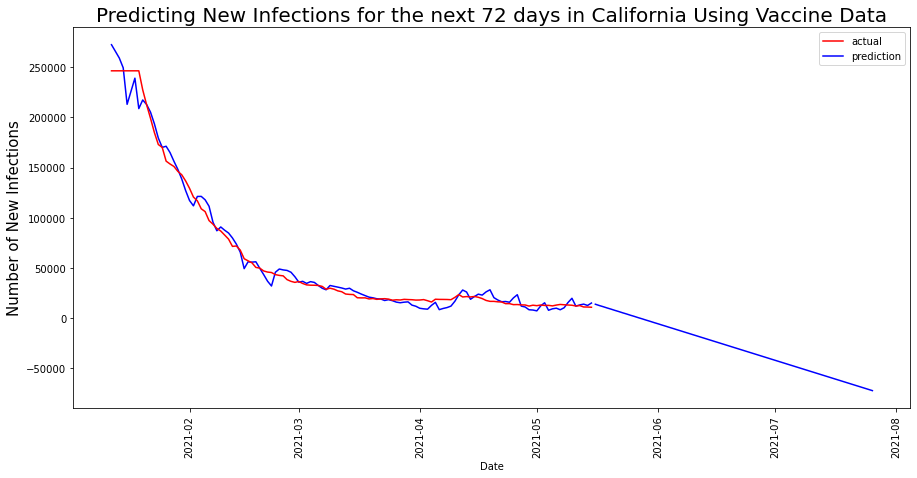

In [60]:
plot_forecasted_new_infections('California', days)

Even though we have a good r^2 score, it seems the prediction model is too agressive in predicting new infections